## **Step 1: Introduction**

In this project, we are going to create an algorithm using CNN to detect metatstatic cancer in small image patches that taken from larger digital pathology scans. The dataset is from Kaggle (https://www.kaggle.com/c/histopathologic-cancer-detection/overview).

In this dataset, we have a train folder that included small images and each file is named with an image id. Also, we have a train_labels.csv file that provides the binary label for each image id. According to Kaggle dataset description, the label is assigned to 1 if at least one pixel of tumor tissue in the center 32*32px region of an image and 0 otherwise. In total, we have 220,025 train images and 57458 test images.

We also have a test folder which we are going to use for prediction, and the default label are all set to 0 in the sample_submission.csv file, our goal is to predict the images in the test folder and update the label in the sample_submission.csv file.

## **Step 2: Exploratory Data Analysis - Inspect, Visualize and Clean**

### 2.1. Load Data

In [84]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

In [88]:
df_train = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
df_sample = test_data = pd.DataFrame({'id':os.listdir("../input/histopathologic-cancer-detection/test/")})

### 2.2. Inspect, Visualize and clean Data 

In [93]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [94]:
df_sample.info()
print(df_sample.head())
print(df_sample['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
label
0    57458
Name: count, dtype: int64


***Based on above information, all the labels in our sample_submission file are unlabeled(set to 0) and we are going to update the label using our model to make predictions.***

In [95]:
print("training dataset number of images: ", len(train_image))
print("testing dataset number of images: ", len(sample_image))

training dataset number of images:  220025
testing dataset number of images:  57458


***Both training_labels.csv and sample_submission.csv files has two columns, the first column contains the image id, and the second column is the label where 1 for that at least one pixel of tumor tissue detected in the center region and 0 otherwise. The test dataset contains unlabeled image ids which is we need to work on later. The dataset is complete and with no missing values, and the total number of images in train/test folder matched the rows in each csv file accordingly.***

Image shape:  (96, 96, 3)


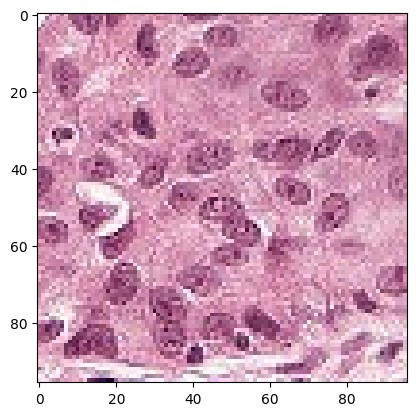

In [96]:
imag_train = Image.open("../input/histopathologic-cancer-detection/train/" + train_image[0])
plt.imshow(imag_train)
print("Image shape: ", np.array(imag_train).shape)

**By calling the shape function of the image, we found that the image size is (96,96,3), and now let us check few more images in different labels to see if we can manually find any differences.**

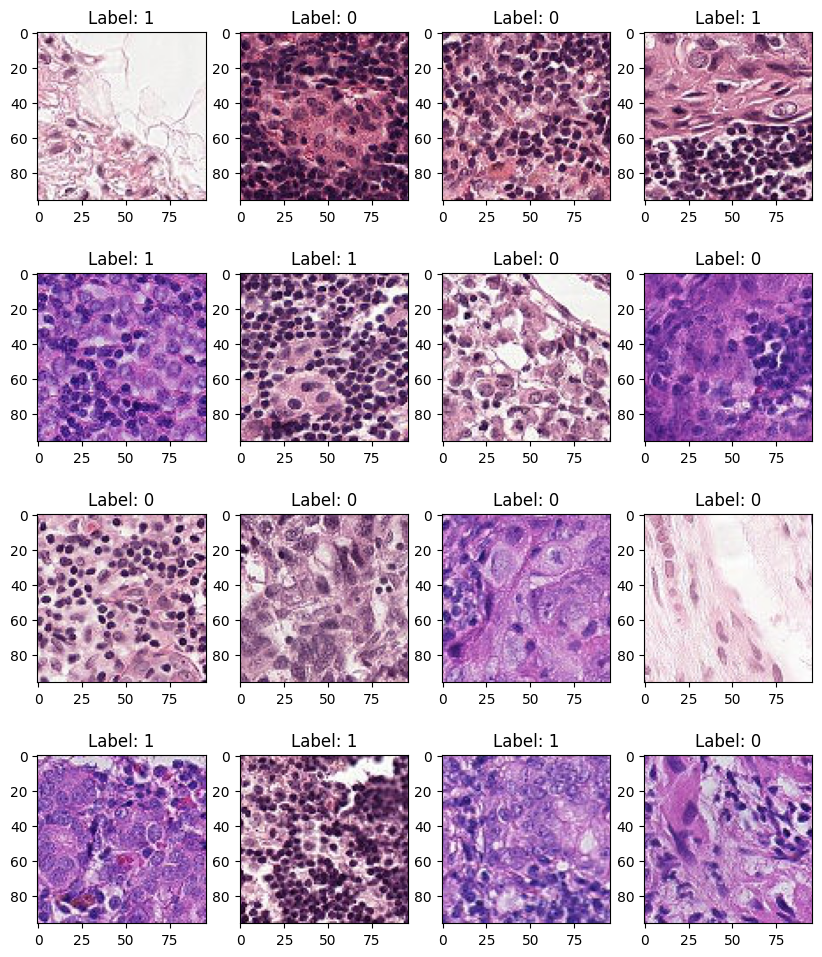

In [97]:
fig = plt.figure(figsize = (10, 12))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    image = Image.open("../input/histopathologic-cancer-detection/train/" + train_image[random.randint(0,80000)])
    plt.imshow(image)
    label = df_train.loc[df_train['id'] == train_image[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {label}')

**By viewing the center of these images, it is very hard to tell the difference between label 0 and label 1 without any professional knowledge. Now let us check the counts of the labels in training data to see if our data is balanced or not.**

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


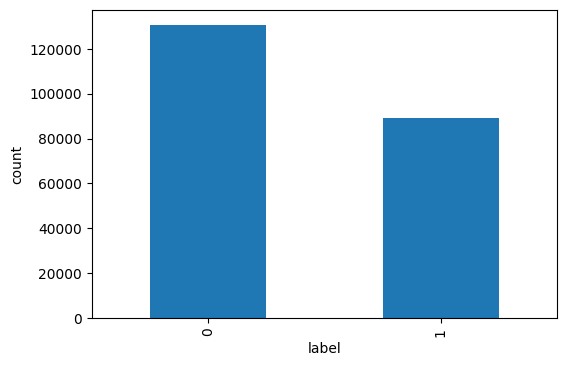

In [98]:
plt.figure(figsize = (6,4))
df_train['label'].value_counts().plot(kind = 'bar')
plt.xlabel("label")
plt.ylabel("count")

print(df_train['label'].value_counts(normalize = True))

***Here is around 60% of training set are detected tumor tissues and 40% are not shown in the image. So the dataset is slightly unbalanced. In order to prevent biased prediction, here we are going to balance the training data. We will reduce the training size down to 80,000 samples for each label by shuffling the dataset and randomly select the samples.***

In [99]:
df = df_train
df['label'] = df['label'].astype(str)
df['id'] = df['id'] + '.tif'

train_0 = df[df['label'] == '0'].sample(80000, random_state = 100)
train_1 = df[df['label'] == '1'].sample(80000, random_state = 100)

df = pd.concat([train_0, train_1], axis = 0).reset_index(drop = True)
df = shuffle(df)

df['label'].value_counts()

label
0    80000
1    80000
Name: count, dtype: int64

In [100]:
# check the dataset after balance and shuffle
df

,id,label
23236,ef90cb05ed07f470f14fad162630bfe0626cd643.tif,0
88326,2d9649b5cc61e0fc2ecb69ace350e1a8913b87d0.tif,1
63863,96aecdb2f136299e9d1cf119271ba4f451170f42.tif,0
150547,c3889b45e5b5fdc42cb158ba7b41770783bae8ef.tif,1
29571,4a1ebf2456ccd88eb38afd5eba421e82fb14c2b0.tif,0
...,...,...
42424,4749aaf2e5fac65bf500480ab125d449fe1e52f2.tif,0
1871,29e786571f45a2b29cabcc8865d3a629a4cfee64.tif,0
90088,56739457b6c0cebe7103faeff431849e2f5416f2.tif,1
151858,e7e70e349278f6f6376df0d33aff9e5aee8c982f.tif,1


## **Step 3: Model Architechture**

In this part, we are going to use CNN with multiple layers, specifically 3 layers in both models, to detect the tumor tissue in the images. Also, the model is compiled using the adam optimizer which is suitable for a binary classification problem. As a CNN model, we learned that the architechture for CNN is like, the input data go through multiple convolutional layers as needed, and pooling, then into a dense function for classification.

I will use ReLu as the activation function for the hidden layers, and then a relu and sigmoid function for the dense layers. For optimizers, I will try Adam with learning rate = 0.0001 for both models, and use binary cross entropy as my loss function.

First, we are going to split training and validation set to 80%, 20% in order to improve our model development. Then we will need to normalize the pixels by rescaling it to 1/255, and additionally we will apply data augmentation techniques to help processing and model training, and increase the diversity of the training data to prevent overfitting.

In [102]:
datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 30, validation_split = 0.2)

In [103]:
train_generator = datagen.flow_from_dataframe(
                dataframe = df, 
                directory = "../input/histopathologic-cancer-detection/train/",
                x_col = "id",
                y_col = "label",
                subset = "training", 
                class_mode = "binary",
                batch_size = 128,
                seed = 100,
                target_size = (64, 64))

Found 128000 validated image filenames belonging to 2 classes.


In [104]:
valid_generator = datagen.flow_from_dataframe(
                dataframe = df, 
                directory = "../input/histopathologic-cancer-detection/train/",
                x_col = "id",
                y_col = "label",
                subset = "validation", 
                class_mode = "binary",
                batch_size = 128,
                seed = 100,
                target_size = (64, 64))

Found 32000 validated image filenames belonging to 2 classes.


### 3.1. Build our first model

In [114]:
model1 = Sequential()

# Add a Conv layer with 32 filters, a 3*3 kernel, and relu activation function, and a maxpooling layer
model1.add(Conv2D(32, (3,3), activation = 'relu'))
model1.add(MaxPooling2D((2, 2)))

# Add a second Conv layer with 64 filters and same kernel and activation function above
model1.add(Conv2D(64, (3, 3), activation = 'relu'))
model1.add(MaxPooling2D((2, 2)))

# Add a third Conv layer with 128 filters
model1.add(Conv2D(128, (3,3), activation = 'relu'))
model1.add(MaxPooling2D((2, 2)))

# Add a flattening layer to convert the 2D to 1D
model1.add(Flatten())
# Add a fully-connected layer with 256 unites and relu activation function
model1.add(Dense(256, activation = 'relu'))
# Add a dropout layer
model1.add(Dropout(0.5))
# add an output layer with binary classification and sigmoid activation function
model1.add(Dense(1, activation = 'sigmoid'))

model1.build(input_shape = (128, 64, 64, 3))
model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (128, 62, 62, 32)         896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (128, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (128, 29, 29, 64)         18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (128, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (128, 12, 12, 128)        73856     
                                                                 
 max_pooling2d_41 (MaxPoolin  (128, 6, 6, 128)       

In [115]:
# Compile the model
opt = Adam(learning_rate = 0.0001)
model1.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])


In [116]:
# Train the model
h1 = model1.fit(train_generator, epochs = 10, validation_data = valid_generator)


Epoch 1/10
1000/1000 [==============================] - 1766s 2s/step - loss: 0.4959 - accuracy: 0.7654 - val_loss: 0.4486 - val_accuracy: 0.7951
Epoch 2/10
1000/1000 [==============================] - 1099s 1s/step - loss: 0.4458 - accuracy: 0.7970 - val_loss: 0.4428 - val_accuracy: 0.7964
Epoch 3/10
1000/1000 [==============================] - 543s 543ms/step - loss: 0.4225 - accuracy: 0.8091 - val_loss: 0.4051 - val_accuracy: 0.8177
Epoch 4/10
1000/1000 [==============================] - 540s 540ms/step - loss: 0.3968 - accuracy: 0.8232 - val_loss: 0.4318 - val_accuracy: 0.8084
Epoch 5/10
1000/1000 [==============================] - 547s 547ms/step - loss: 0.3834 - accuracy: 0.8298 - val_loss: 0.3863 - val_accuracy: 0.8273
Epoch 6/10
1000/1000 [==============================] - 557s 557ms/step - loss: 0.3701 - accuracy: 0.8363 - val_loss: 0.3528 - val_accuracy: 0.8439
Epoch 7/10
1000/1000 [==============================] - 511s 511ms/step - loss: 0.3565 - accuracy: 0.8429 - val_loss

### Build our second model

In this model, we only add a batch normalization layer after each convolution layer and dropout layer at the end, and remain the other hyperparameters the same as the first model to see if we could get a better performance. 

In [150]:
model2 = Sequential()

# Add a Conv layer with 32 filters, a 3*3 kernel, and relu activation function, and a maxpooling layer
model2.add(Conv2D(32, (3,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D((2, 2)))

# Add a second Conv layer with 64 filters and same kernel and activation function above
model2.add(Conv2D(64, (3, 3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D((2, 2)))

# Add a third Conv layer with 128 filters
model2.add(Conv2D(128, (3,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D((2, 2)))

# Add a flattening layer to convert the 2D to 1D
model2.add(Flatten())
# Add a fully-connected layer with 256 unites and relu activation function
model2.add(Dense(256, activation = 'relu'))
# Add a dropout layer
model2.add(Dropout(0.5))
# add an output layer with binary classification and sigmoid activation function
model2.add(Dense(1, activation = 'sigmoid'))

model2.build(input_shape = (128, 64, 64, 3))
model2.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (128, 62, 62, 32)         896       
                                                                 
 batch_normalization_51 (Bat  (128, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 activation_41 (Activation)  (128, 62, 62, 32)         0         
                                                                 
 max_pooling2d_74 (MaxPoolin  (128, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (128, 29, 29, 64)         18496     
                                                                 
 batch_normalization_52 (Bat  (128, 29, 29, 64)      

In [151]:
opt2 = Adam(learning_rate = 0.0001)
model2.compile(optimizer = opt2, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [152]:
h2 = model2.fit(train_generator, epochs = 10, validation_data = valid_generator)

Epoch 1/10
1000/1000 [==============================] - 655s 653ms/step - loss: 0.4398 - accuracy: 0.7986 - val_loss: 0.4246 - val_accuracy: 0.8099
Epoch 2/10
1000/1000 [==============================] - 588s 588ms/step - loss: 0.3803 - accuracy: 0.8312 - val_loss: 0.4411 - val_accuracy: 0.7937
Epoch 3/10
1000/1000 [==============================] - 596s 595ms/step - loss: 0.3529 - accuracy: 0.8477 - val_loss: 0.3455 - val_accuracy: 0.8523
Epoch 4/10
1000/1000 [==============================] - 616s 616ms/step - loss: 0.3363 - accuracy: 0.8560 - val_loss: 0.5368 - val_accuracy: 0.7785
Epoch 5/10
1000/1000 [==============================] - 1069s 1s/step - loss: 0.3212 - accuracy: 0.8640 - val_loss: 0.3105 - val_accuracy: 0.8666
Epoch 6/10
1000/1000 [==============================] - 1255s 1s/step - loss: 0.3099 - accuracy: 0.8696 - val_loss: 0.3073 - val_accuracy: 0.8680
Epoch 7/10
1000/1000 [==============================] - 612s 612ms/step - loss: 0.3012 - accuracy: 0.8735 - val_loss

## **Step4: Results and Analysis**
### Let's check the accuracy and loss value in our first model

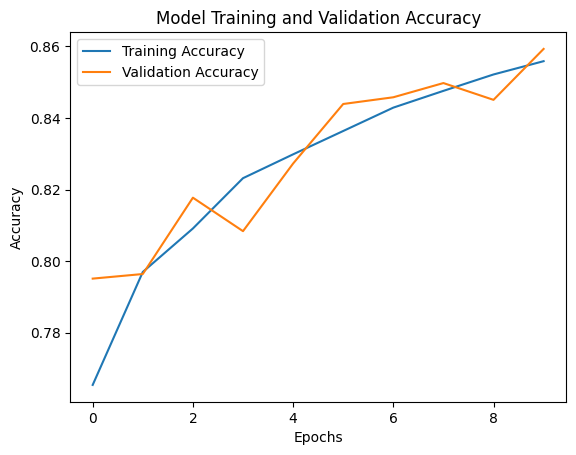

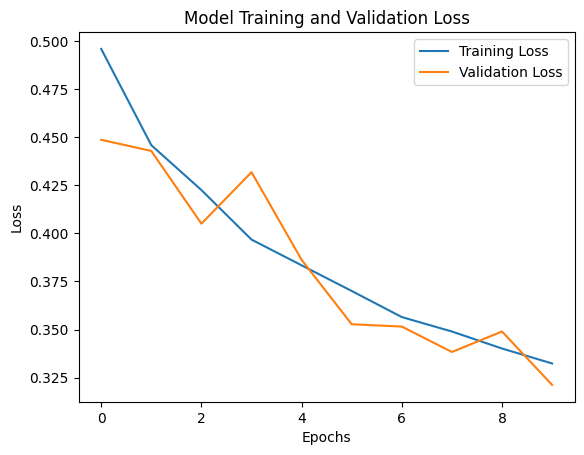

In [118]:
acc = h1.history["accuracy"]
val_acc = h1.history["val_accuracy"]
loss = h1.history["loss"]
val_loss = h1.history["val_loss"]

plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.title("Model 1 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.title("Model 1 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Let's check our second model

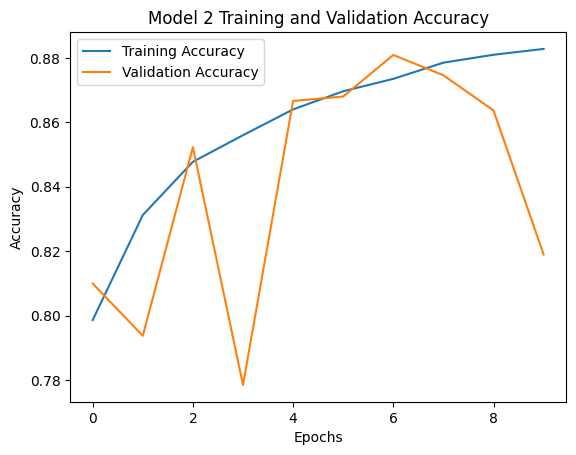

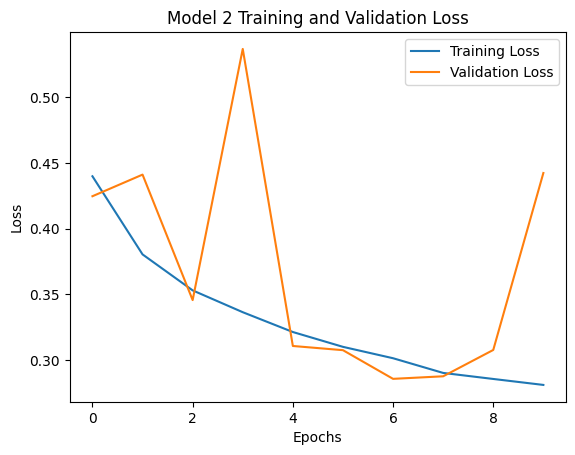

In [153]:
acc2 = h2.history["accuracy"]
val_acc2 = h2.history["val_accuracy"]
loss2 = h2.history["loss"]
val_loss2 = h2.history["val_loss"]

plt.plot(acc2, label = "Training Accuracy")
plt.plot(val_acc2, label = "Validation Accuracy")
plt.title("Model 2 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(loss2, label = "Training Loss")
plt.plot(val_loss2, label = "Validation Loss")
plt.title("Model 2 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**In the beginning of the second model, I was trying to add a dropout layer to each convolution layer, however, it has increased the training time significantly, so I have to take out those dropout layers and just leave one at the end of the model.**

**In our first model, the training accuracy was increased from 0.765 to 0.856 as its final accuracy, and the loss value was decreased from 0.496 to 0.332. And in our second model, the accuracy was slightly higher than our first model, which was 0.799, at the end of the training, the accuracy increased to 0.8828, also, the final loss value is 0.2809. Both values from training dataset are better than the first model. However, compare the validation accuracy of first model to the second model, the first model was actually doing better. The second model at the end was overfitting.**

**So it looks like the model with batch normalization performed better than the first model at the beginning, I may need to reduce the epoch numbers. In fact, batch normalization is commonly use in Deep Learning, and it provides regularization, and avoiding overfitting.**

## **Step 5: Conclusion**

In conclusion, by using both models with three convolution layers, both models were able to perform well on both training data and validation data. The second model with batch normalization had a higher accuracy and a lower loss. However, if I have another chance, I may have a smaller number for the epoch, I chose epoch=10 and it took much longer training time. I really enjoyed this mini project and it made me learn a lot in Convolutional Neural Networks and how to use Keras for implementing neural networks.

### Prediction on Test Data and Submission

In [175]:
datagen = ImageDataGenerator(rescale = 1./255)

test_generator = datagen.flow_from_dataframe(
    dataframe = df_sample,
    directory = "../input/histopathologic-cancer-detection/test/",
    x_col = 'id',
    y_col = None,
    class_mode = None,
    batch_size = 1,
    shuffle = False,
    target_size = (64, 64))

Found 57458 validated image filenames.


In [176]:
# predict
pred = model2.predict(test_generator, verbose = 1)

57458/57458 [==============================] - 276s 5ms/step


In [177]:
predictions = []

for pr in pred:
    if pr >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

In [178]:
submission = df_sample
submission['id'] = df_sample['id'].str[:-4]
submission['label'] = predictions
submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [179]:
submission.to_csv('submission2.csv', index = False)